Scraped 19 tickers.


[*********************100%***********************]  19 of 19 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['MSTR-USD', 'LCS-USD', 'SUI-USD', 'TRADE-USD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-04-23 -> 2025-04-27)')


Fetched returns for 19 tickers.


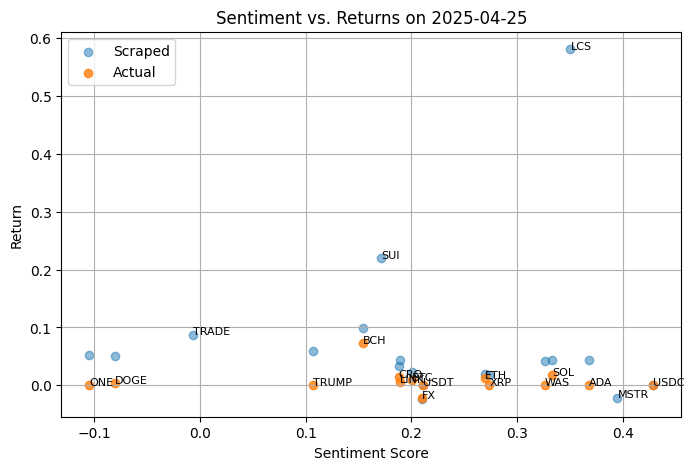

Pearson correlation: r = -0.051, p-value = 0.856
→ p ≥ 0.05: cannot reject H₀, no significant correlation.


In [1]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import traceback
from scipy.stats import pearsonr


# Scrape Reddit sentiment score of cryptocurrencies for a single day

def scrape_reddit_mentions(url):
    headers = {"User-Agent": "Mozilla/5.0"}

    r = requests.get(url, headers=headers)
    r.raise_for_status()
    soup = BeautifulSoup(r.content, 'html.parser')
    rows = []
    for tr in soup.find_all("tr"):
      cols = [td.get("data-value", td.get_text(strip=True)).strip() for td in tr.find_all("td")]
      if cols and len(cols) >= 8 and cols[2] == "crypto":
        rows.append(cols)

    df = pd.DataFrame(rows, columns=['rank','ticker','category','name','mentions','mentions_change_pct','sentiment_score','price_change'])
    df = df[['ticker','sentiment_score','price_change']]
    df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')
    df['price_change']     = pd.to_numeric(df['price_change'], errors='coerce')
    df.dropna(subset=['sentiment_score','price_change'], inplace=True)
    return df



# Fetch actual price data from Yahoo Finance and calculate returns

def fetch_next_day_returns(tickers, sentiment_date):
    records = []
    start = sentiment_date - timedelta(days=1)
    end   = sentiment_date + timedelta(days=3)

    yf_syms = [t + '-USD' for t in tickers]
    raw = yf.download(tickers=yf_syms, start=start.isoformat(), end=end.isoformat(),group_by='ticker', auto_adjust=False, threads=True)
    multi = hasattr(raw.columns, 'levels')
    for t,sym in zip(tickers, yf_syms):
      df_sym = (raw[sym] if multi else raw).reset_index()[['Date','Close']]
      df_sym['Date'] = df_sym['Date'].dt.date
      df_sym = df_sym[df_sym['Date'] >= sentiment_date].sort_values('Date').head(2)
      if len(df_sym) < 2:
        continue
      p0,p1 = df_sym['Close'].iloc[0], df_sym['Close'].iloc[1]
      records.append({'ticker': t, 'ActualReturn': (p1-p0)/p0})

    return pd.DataFrame(records)

# Append daily findings to the longitudinal dataset

def save_daily_results(sent_df, ret_df, sentiment_date, csv_path='daily_crypto_sentiment.csv'):
    df = sent_df.merge(ret_df, on='ticker', how='left')
    df = df.rename(columns={'price_change':'chart_price_change'})
    df = df[['ticker','sentiment_score','ActualReturn']].copy()
    df['date'] = sentiment_date
    header = not os.path.exists(csv_path)
    df.to_csv(csv_path, mode='a', index=False, header=header)


# Pearson hypothesis test on the accumulated data

def run_hypothesis_test(csv_path='daily_crypto_sentiment.csv', alpha=0.05):
    df = pd.read_csv(csv_path, parse_dates=['date']).dropna(subset=['ActualReturn'])

    r, pval = pearsonr(df['sentiment_score'], df['ActualReturn'])
    print(f"Pearson correlation: r = {r:.3f}, p-value = {pval:.3f}")
    if pval < alpha:
        print(f"→ p < {alpha}: reject H₀, significant correlation.")
    else:
        print(f"→ p ≥ {alpha}: cannot reject H₀, no significant correlation.")


# Plot scraped vs actual returns for single day

def plot_single_day(sent_df, ret_df):

    df = sent_df.merge(ret_df, on='ticker', how='left')
    plt.figure(figsize=(8,5))
    plt.scatter(df['sentiment_score'], df['price_change']/100, label='Scraped', alpha=0.5)
    actual = df.dropna(subset=['ActualReturn'])
    if not actual.empty:
        plt.scatter(actual['sentiment_score'], actual['ActualReturn'], label='Actual', alpha=0.8)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Return')
    plt.title(f'Sentiment vs. Returns on {datetime.today().date()}')
    plt.legend(); plt.grid(True)
    for _,row in df.iterrows():
        y = row['ActualReturn'] if pd.notna(row['ActualReturn']) else row['price_change']/100
        plt.annotate(row['ticker'], (row['sentiment_score'], y), fontsize=8)
    plt.show()


# Main execution

if __name__ == '__main__':
    url = "https://chartexchange.com/trends/reddit/mentions/cx-all/"
    sentiment_date = datetime.today().date() - timedelta(days=1)
    sent_df = scrape_reddit_mentions(url)
    print(f"Scraped {len(sent_df)} tickers.")
    ret_df = fetch_next_day_returns(sent_df['ticker'].tolist(), sentiment_date)
    print(f"Fetched returns for {len(ret_df)} tickers.")
    save_daily_results(sent_df, ret_df, sentiment_date)
    plot_single_day(sent_df, ret_df)
    run_hypothesis_test() # aggregation of all tests